# 10. Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin. 

> 🔑 **Note:** ⚠️ This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

![example time series problems](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-example-time-series-problems.png)

| Problem Type | Examples | Output |
| ----- | ----- | ----- |
| **Classification** | Anomaly detection, time series identification (where did this time series come from?) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future demand for a product, stocking inventory requirements | Continuous (a number) |

In both cases above, a supervised learning approach is often used. Meaning, you'd have some example data and a label assosciated with that data.

For example, in forecasting the price of Bitcoin, your data could be the historical price of Bitcoin for the past month and the label could be today's price (the label can't be tomorrow's price because that's what we'd want to predict).

Can you guess what kind of problem BitPredict is?


> 📖 **Resource:** Get all of the materials you need for this notebook on the [course GitHub](https://github.com/mrdbourke/tensorflow-deep-learning).




## Get data

We're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

If you're going through this notebook at a later date, you'll be able to use what you learn to predict on later dates of Bitcoin, you'll just have to adjust the data source.

> 📖 **Resource:** To get the Bitcoin historical data, I went to the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), clicked on "all" and then clicked on "Export data" and selected "CSV". 

You can find the data we're going to use on [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).



In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 

import tensorflow as tf
from tensorflow.keras import layers

from pathlib import Path

In [2]:
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-03 13:19:15--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_     [ <=>                ]   1.08M  --.-KB/s    in 0.04s   

2023-03-03 13:19:15 (27.3 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [1130953]



### Importing time series data with pandas

Our data is in **CSV (comma separated values)** format, we'll use the pandas [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column ("Date").

In [3]:
path = Path.cwd() / "BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
df = pd.read_html(path, 
                  parse_dates=["Date"],
                  index_col=["Date"])[0]

df = df.drop("Unnamed: 0", axis=1)

<AxesSubplot:xlabel='Date'>

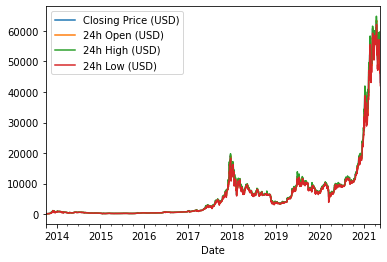

In [4]:
df.plot()

In [5]:
df.info(), len(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


(None, 2787)

In [6]:
df.isna().sum()

Currency               0
Closing Price (USD)    0
24h Open (USD)         0
24h High (USD)         0
24h Low (USD)          0
dtype: int64

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

| 1 sample per timeframe | Number of samples per year |
| ----- | ----- |
| Second | 31,536,000 |
| Hour | 8,760 |
| Day | 365 |
| Week | 52 |
| Month | 12 |

> 🔑 **Note:** The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months). For more on different time series patterns, see [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html).

![different types of time series patterns](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-types-of-time-series-patterns.png)
*Example of different kinds of patterns you'll see in time series data. Notice the bottom right time series (Google stock price changes) has little to no patterns, making it difficult to predict. See [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html) for full graphic.*

Deep learning algorithms usually flourish with lots of data, in the range of thousands to millions of samples.

In our case, we've got the daily prices of Bitcoin, a max of 365 samples per year.

But that doesn't we can't try them with our data.

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [7]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "price"})
bitcoin_prices

,price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


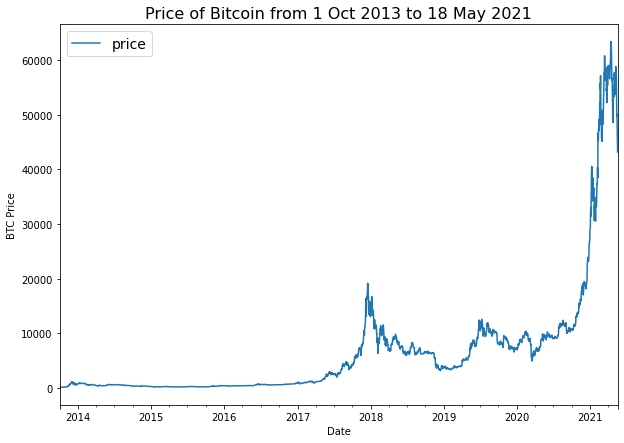

In [8]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Format Data Part 1: Creatining train and test sets for time series data

Usually, you could create a train and test split using a function like Scikit-Learn's outstanding [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) but as we'll see in a moment, this doesn't really cut it for time series data.

But before we do create splits, it's worth talking about what *kind* of data we have.

In time series problems, you'll either have **univariate** or **multivariate** data.

Can you guess what our data is?

* **Univariate** time series data deals with *one* variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* **Multivariate** time series data deals with *more than one* variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

![comparison of univariate and multivariate time series data](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-univariate-and-multivariate-time-series-data.png)
*Example of univariate and multivariate time series data. Univariate involves using the target to predict the target. Multivariate inolves using the target as well as another time series to predict the target.*

### Create train & test sets for time series (the right way)

Of course, there's no way we can actually access data from the future.

But we can engineer our test set to be in the future with respect to the training set.

To do this, we can create an abitrary point in time to split our data.

Everything before the point in time can be considered the training set and everything after the point in time can be considered the test set.

![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)
*Demonstration of time series split. Rather than a traditionaly random train/test split, it's best to split the time series data sequentially. Meaning, the test data should be data from the future when compared to the training data.*

In [9]:
timesteps = bitcoin_prices.index.to_numpy()
price = bitcoin_prices.price.to_numpy()

split_size = int(0.8*len(price))

X_train, y_train = timesteps[:split_size], price[:split_size]
X_test, y_test = timesteps[split_size:], price[split_size:]

len(X_train), len(X_test)

(2229, 558)

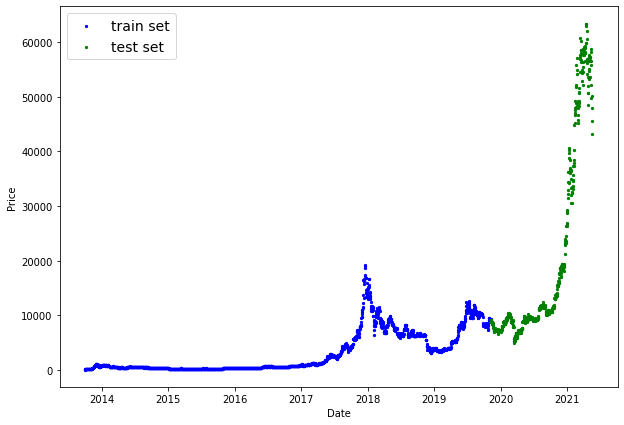

In [10]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, c="blue",label="train set")
plt.scatter(X_test, y_test, s=5, c="green", label="test set")
plt.legend(fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [11]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None, figsize=None):

    if figsize is not None:
        plt.figure(figsize=figsize)

    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

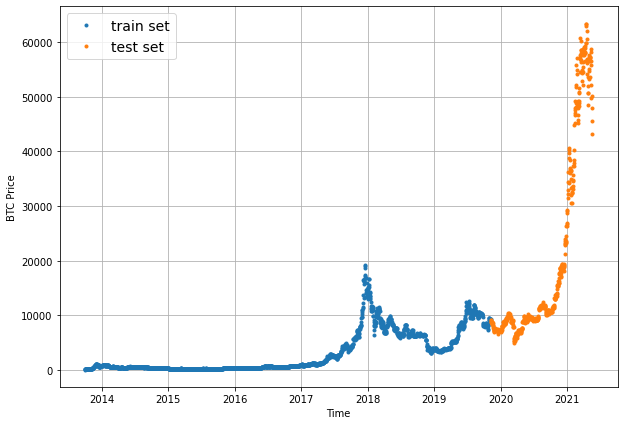

In [12]:
plot_time_series(X_train, y_train, label="train set", figsize=(10,7))
plot_time_series(X_test, y_test, label="test set")

## Modelling Experiments

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.

However, just because we *can* build *almost any* kind of model, doesn't mean it'll perform well/should be used in a production setting.

We'll see what this means as we build and evaluate models throughout.

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA | 
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA | 
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA| 
| 10 | Same as 1 (but with turkey data introduced) | 1 | 7 | NA |

> 🔑 **Note:** To reiterate, as you can see, we can build many types of models for the data we're working with. But that doesn't mean that they'll perform well. Deep learning is a powerful technique but it doesn't always work. And as always, start with a simple model first and then add complexity as needed. 

## Model 0: Naïve forecast (baseline)

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

$$\hat{y}_{t} = y_{t-1}$$ 

| X_test | $X_1$ | $X_2$ | ... | $X_{n}$ |
|-----|-----|-----|-----|-----|
| y_test | $y_1$ | $y_2$ | ... | $y_{n}$ |

| baseline_features | $X_2$ | $X_2$ | ... | $X_{n}$ |
|-----|-----|-----|-----|-----|
| baseline_preds | $y_1$ | $y_2$ | ... | $y_{n-1}$ |
| True_preds | $y_2$ | $y_2$ | ... | $y_{n}$ |

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

> 🔑 **Note:** For the sake of this notebook, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [13]:
baseline_preds = y_test[:-1]
baseline_features = X_test[1:]
true_preds = y_test[1:]

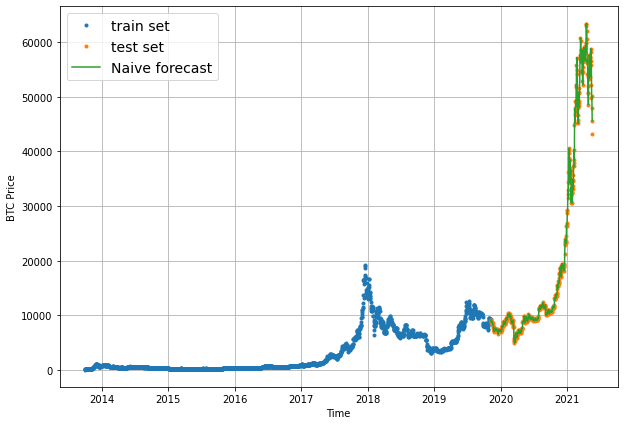

In [14]:
plot_time_series(X_train, y_train, figsize=(10,7), label="train set")
plot_time_series(X_test, y_test, label="test set")
plot_time_series(baseline_features, baseline_preds, format="-", label="Naive forecast")

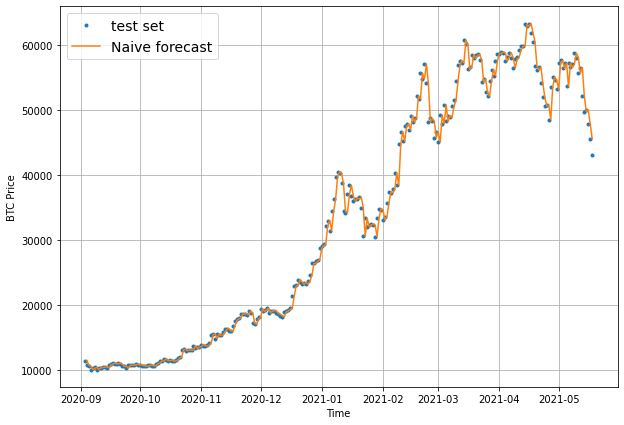

In [15]:
offset = 300
plot_time_series(X_test, y_test, label="test set", start=offset, figsize=(10,7))
plot_time_series(baseline_features, baseline_preds, format="-", label="Naive forecast", start=offset)

## Evaluating a time series model

Time series forecasting often involves predicting a number (in our case, the price of Bitcoin). $\Rightarrow$ **REGRESSION**

The main thing we will be evaluating is: **how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or *ground truth values*)**? 

> 📖 **Resource :** The metrics to evaluate our different model's time series forecast accuracy, are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html)

For all of the following metrics, **lower is better** $\rightarrow$ MAE:0 > MAE:100

### Scale-dependent errors

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

| Metric | Code |
| -----  | ----- |
| **MAE** (mean absolute error)  | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get < 1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

Since we're going to be evaluing a lot of models, let's write a function to help us calculate evaluation metrics on their forecasts.


$${\displaystyle \mathrm {MASE} =\mathrm {mean} \left({\frac {\left|e_{j}\right|}{{\frac {1}{T-1}}\sum _{t=2}^{T}\left|Y_{t}-Y_{t-1}\right|}}\right)={\frac {{\frac {1}{J}}\sum _{j}\left|e_{j}\right|}{{\frac {1}{T-1}}\sum _{t=2}^{T}\left|Y_{t}-Y_{t-1}\right|}}}$$

In [16]:
def mean_absolute_scaled_error(y_true, y_pred):
    numerator = tf.reduce_mean(tf.abs(y_true - y_pred)) # MAE 
    denominator = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return numerator/denominator

You'll notice the version of MASE above doesn't take in the training values like sktime's `mae_loss()`. In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of > 1 and any model better than the naïve forecast will achieve an MASE of < 1.

In [17]:
def evaluate(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [18]:
baseline_scores = evaluate(true_preds, baseline_preds)
baseline_scores

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Alright, looks like we've got some baselines to beat.

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [19]:
tf.reduce_mean(y_test).numpy()

20056.632963737222

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

There are many other kinds of models you may want to look into for building baselines/performing forecasts.

Some of them may even beat our best performing models in this notebook, however, I'll leave trying them out for extra-curriculum.

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats | 
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

We've got to window our time series.
<br>
Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

* Horizon: The number of timesteps into the future we want to predict Window
* size: The number of timesteps we're going to use to predict the horizon

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

![windows and horizons for turning time series data into a supervised learning problem](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-windows-and-horizons.png)
*Example of windows and horizons for Bitcoin data. Windowing can be used to turn time series data into a supervised learning problem.*

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, I've just picked them).

In [20]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [21]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [[1, 2, 3, 4, 5, 6]] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  window_array = x[:, :-horizon]
  horizon_array = x[:, -horizon:]
  return window_array, horizon_array

In [22]:
get_labelled_windows(np.array([[1,2,3,4,5,6]]))

(array([[1, 2, 3, 4, 5]]), array([[6]]))

In [23]:
get_labelled_windows(np.array([[0, 1, 2, 3, 4],
                                [1, 2, 3, 4, 5],
                                [2, 3, 4, 5, 6],
                                [3, 4, 5, 6, 7],
                                [4, 5, 6, 7, 8],
                                [5, 6, 7, 8, 9]]))

(array([[0, 1, 2, 3],
        [1, 2, 3, 4],
        [2, 3, 4, 5],
        [3, 4, 5, 6],
        [4, 5, 6, 7],
        [5, 6, 7, 8]]), array([[4],
        [5],
        [6],
        [7],
        [8],
        [9]]))

In [24]:
aa = np.expand_dims(np.random.randint(0,10,(5,)), axis=0)
bb = np.expand_dims(np.random.randint(0,10,(5,)), axis=1)
print(aa)
print(bb)
aa + bb

[[4 2 6 2 8]]
[[5]
 [6]
 [5]
 [5]
 [8]]


array([[ 9,  7, 11,  7, 13],
       [10,  8, 12,  8, 14],
       [ 9,  7, 11,  7, 13],
       [ 9,  7, 11,  7, 13],
       [12, 10, 14, 10, 16]])

In [25]:
price = np.random.randint(0,10,(10,))
b = np.expand_dims(np.arange(5), axis=0) # np.arange(5).reshape((1,5))
c = np.expand_dims(np.arange(len(price)-(5-1)), axis=1)
print(price)
print(b)
print(c)

[3 8 0 8 0 7 6 7 3 2]
[[0 1 2 3 4]]
[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


In [26]:
b+c # 9 is the max of a+b and also the price index max

array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8],
       [5, 6, 7, 8, 9]])

In [27]:
price[b+c]

array([[3, 8, 0, 8, 0],
       [8, 0, 8, 0, 7],
       [0, 8, 0, 7, 6],
       [8, 0, 7, 6, 7],
       [0, 7, 6, 7, 3],
       [7, 6, 7, 3, 2]])

In [28]:
def make_windows(x, window_size:int=WINDOW_SIZE, horizon:int=HORIZON):
    """
    input : np.array([1,2,3,...,10])
    
    output: np.array([
        [1,2,...,7],
        [2,3,...,8],
        [3,4,...,9]
    ]),
    np.array([8,9,10])
    """
    raw_size = window_size + horizon
    column_size = len(x) - raw_size + 1

    raw_index = np.expand_dims(np.arange(raw_size), axis=0) # [[0,1,2,...,n]]
    column_index = np.expand_dims(np.arange(column_size), axis=1) # [[1],[2],...,[p]]

    window_index = raw_index + column_index
    windowed_array = x[window_index]

    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels


In [29]:
price = bitcoin_prices.price.to_numpy()
full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)

for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")
    
print("features : ", full_windows.shape, full_windows[0].shape)
print("target : ", full_labels.shape, full_labels[0].shape)

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]
features :  (2780, 7) (7,)
target :  (2780, 1) (1,)


In [30]:
def train_test_split_timeseries(windows, labels, test_size=0.2):
    train_size = int((1 - test_size) * len(windows))
    train_windows = windows[:train_size]
    test_windows = windows[train_size:]
    train_labels = labels[:train_size]
    test_labels = labels[train_size:]
    
    return train_windows, test_windows, train_labels, test_labels

In [31]:
train_windows, test_windows, train_labels, test_labels = train_test_split_timeseries(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [32]:
train_windows.shape, len(train_windows[-1])

((2224, 7), 7)

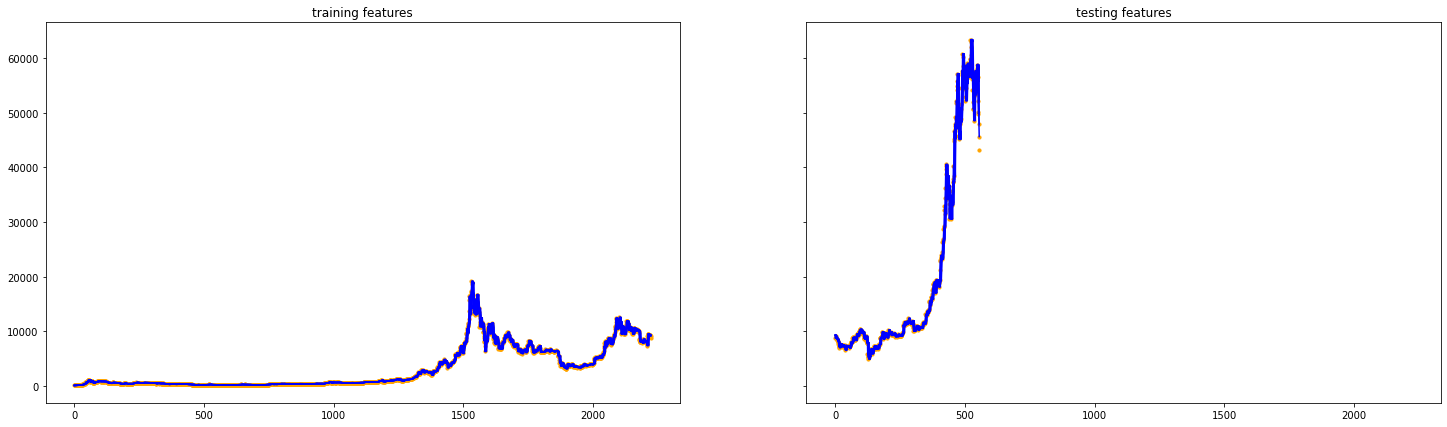

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(25,7))

ax1.set_title("training features")
ax1.plot(train_windows, c="blue")
ax1.scatter(np.arange(len(train_labels)), train_labels, s=10, c="orange")

ax2.set_title("testing features")
ax2.plot(test_windows, c="blue")
ax2.scatter(np.arange(len(test_labels)), test_labels, s=10, c="orange")

plt.show()

### Format data with tensorflow : `tf.data.Dataset`

Creating dataset using `window()` method 
1. First create dataset -> Ex : `tf.Tensor(1,2,3,4,5,6)`
1. Secondly create window -> `VariantDataset`
1. Thirdly flat and batch -> Ex batch=4 : 
```
tf.Tensor([1,2,3,4])
tf.Tensor([2,3,4,5])
tf.Tensor([3,4,5,6])
```
1. Forthly create horizon -> EX :
```
(tf.Tensor([1,2,3]), tf.Tensor([4]))
(tf.Tensor([2,3,4]), tf.Tensor([5]))
(tf.Tensor([3,4,5]), tf.Tensor([6]))
```

> 🔑 **Note:** You can find an other function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array).

* Horizon: The number of timesteps into the future we want to predict Window
* size: The number of timesteps we're going to use to predict the horizon


In [34]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "price"})

timesteps = bitcoin_prices.index.to_numpy()
price = bitcoin_prices.price.to_numpy()

train_size = int(0.8 * len(price))

train_price = price[:train_size]
train_timesteps = timesteps[:train_size]

test_price = price[train_size:]
test_timesteps = timesteps[train_size:]

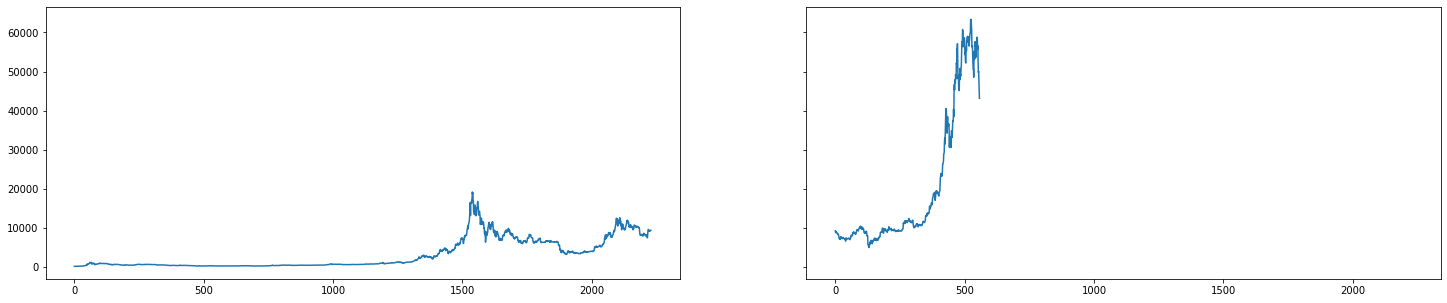

In [35]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(25,5))
axs[0].plot(train_price)
axs[1].plot(test_price);

In [36]:
step_size = 1
window_size = 7 + step_size
train_dataset = tf.data.Dataset.from_tensor_slices(train_price)
train_dataset = train_dataset.window(window_size, shift=step_size, drop_remainder=True)
# The drop_remainder parameter specifies whether to drop the final elements of the dataset if the remaining elements are fewer than the window_size
train_dataset = train_dataset.flat_map(lambda x: x.batch(window_size))
train_dataset = train_dataset.map(lambda x: (x[:-1], x[-1:])).batch(32)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [37]:
for train_price, target in train_dataset.take(1):
    for i in range(3): 
        print(f"Window: {train_price[i]} -> Label: {target[i]} \n")
    
    print("features : ", train_price.shape, train_price[0].shape) # batch=32
    print("target : ", target.shape, target[0].shape)

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033] 

Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049] 

Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116] 

features :  (32, 7) (7,)
target :  (32, 1) (1,)


In [38]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [39]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_price)
test_dataset = test_dataset.window(window_size, shift=step_size, drop_remainder=True)
test_dataset = test_dataset.flat_map(lambda x: x.batch(window_size))
test_dataset = test_dataset.map(lambda x: (x[:-1], x[-1:])).batch(32).prefetch(tf.data.AUTOTUNE)

## Make a modelling checkpoint


If `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To take of this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating our model we could restore its best performing configuration from file.




In [40]:
def create_model_checkpoint(model_name, save_path="model_experience"):
    path = Path.cwd() / save_path / model_name
    return tf.keras.callbacks.ModelCheckpoint(path, save_best_only=True, verbose=False)

## Model 1: Dense model (window = 7, horizon = 1)

We're going to start by keeping it simple, `model_1` will have:
* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 32
* 100 epochs


### Testing with our own dataset

In [85]:
%%time
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
     layers.Input(shape=(7,)),
     layers.Dense(128, activation="relu"),
     layers.Dense(HORIZON, activation="linear") # Same as having no activation
 ], name="model_1")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=False,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

CPU times: user 39.5 s, sys: 2.19 s, total: 41.7 s
Wall time: 41.6 s


In [86]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 6ms/step - loss: 685.7609 - mae: 685.7609


[685.7608642578125, 685.7608642578125]

In [87]:
model_1 = tf.keras.models.load_model("model_experience/model_1")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 563.3740 - mae: 563.3740


[563.3739624023438, 563.3739624023438]

### Testing with tensorflow Dataset

In [ ]:
%%time
tf.random.set_seed(42)

model_1_dataset = tf.keras.Sequential([
     layers.Input(shape=(7,)),
     layers.Dense(128, activation="relu"),
     layers.Dense(HORIZON, activation="linear")
 ], name="model_1_dataset")

model_1_dataset.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) 

model_1_dataset.fit(train_dataset, 
                    epochs=100,
                    verbose=False,
                    validation_data= test_dataset,
                    callbacks=[create_model_checkpoint(model_name=model_1_dataset.name)])

CPU times: user 1min 19s, sys: 6.45 s, total: 1min 26s
Wall time: 1min 37s


In [ ]:
model_1_dataset.evaluate(test_dataset)

18/18 [==============================] - 0s 10ms/step - loss: 770.4559 - mae: 770.4559


[770.4558715820312, 770.4558715820312]

In [ ]:
model_1_dataset = tf.keras.models.load_model("model_experience/model_1_dataset")
model_1_dataset.evaluate(test_dataset)

18/18 [==============================] - 0s 9ms/step - loss: 628.6622 - mae: 628.6622


[628.6621704101562, 628.6621704101562]

Same Resulte between our own dataset and tensorflow dataset <br>
**BUT**<br>
**tensorflow dataset are very slow**

## Making forecasts with a model (on the test dataset)

Since we're going to be running more modelling experiments, let's write a function which: 
1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on) 
3. Passes the input data to the model's `predict()` method
4. Returns the predictions



In [ ]:
model_1.predict(test_windows).shape

18/18 [==============================] - 0s 2ms/step


(556, 1)

In [ ]:
test_labels.shape

(556, 1)

Shape (X, 1)

Squeeze both, else => error in `evaluate` fct

In [41]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [88]:
preds_1 = make_preds(model_1, test_windows)
preds_1.shape

18/18 [==============================] - 0s 2ms/step


TensorShape([556])

In [ ]:
preds_1_dataset = make_preds(model_1_dataset, test_dataset)
preds_1_dataset.shape

18/18 [==============================] - 0s 6ms/step


TensorShape([551])

> 🔑 **Note:** With these outputs, our model isn't *forecasting* yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture

In [89]:
scores_1 = evaluate(tf.squeeze(test_labels), preds_1)
scores_1

{'mae': 563.37396,
 'mse': 1151846.6,
 'rmse': 1073.2412,
 'mape': 2.5034986,
 'mase': 0.98969203}

In [ ]:
targets = []
for _, target in test_dataset.take(-1):
    targets.extend(target)
targets = np.array(targets)

In [ ]:
scores_1_dataset = evaluate(tf.squeeze(targets), preds_1_dataset)
scores_1_dataset

{'mae': 628.6622,
 'mse': 1296908.5,
 'rmse': 1138.8188,
 'mape': 2.8495781,
 'mase': 1.0972354}

Did it beat the naïve forecast ?

In [ ]:
baseline_scores

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [42]:
def compare_scores(scores_1, scores_2=baseline_scores):
    for key, score in scores_2.items():
        print(f"Delta {key} : {score - scores_1[key] :.4f}")

In [ ]:
print("custom dataset")
compare_scores(scores_1)
print("\ntensorflow dataset")
compare_scores(scores_1_dataset)
print("\nfirst two model")
compare_scores(scores_1_dataset, scores_1)

custom dataset
Delta mae : 5.5154
Delta mse : -4760.1250
Delta rmse : -2.2195
Delta mape : -0.0059
Delta mase : 0.0115

tensorflow dataset
Delta mae : -60.6819
Delta mse : -149361.5000
Delta rmse : -67.5826
Delta mape : -0.3331
Delta mase : -0.0977

first two model
Delta mae : -66.1974
Delta mse : -144601.3750
Delta rmse : -65.3632
Delta mape : -0.3271
Delta mase : -0.1091


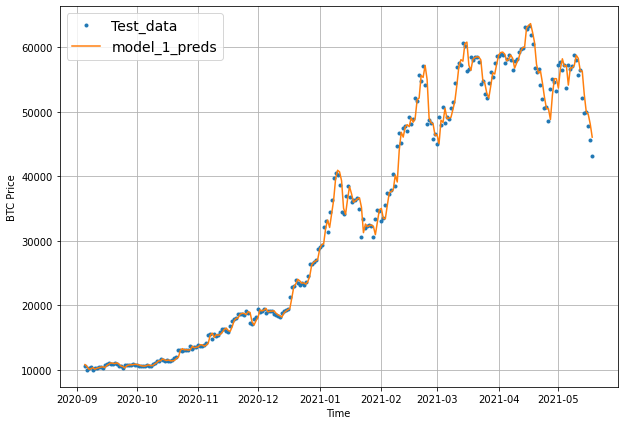

In [ ]:
offset = 300
timesteps = X_test[-len(test_windows):]

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=timesteps, values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=timesteps, values=preds_1, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)

We'll keep the previous model architecture but use a window size of 30.

In other words, we'll use the previous 30 days of Bitcoin prices to try and predict the next day price.

![bitcoin prices windowed for 30 days to predict a horizon of 1 day](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-price-window-for-one-month.png)
*Example of Bitcoin prices windowed for 30 days to predict a horizon of 1.*

> 🔑 **Note:** Recall from before, the window size (how many timesteps to use to fuel a forecast) and the horizon (how many timesteps to predict into the future) are **hyperparameters**. This means you can tune them to try and find values will result in better performance.
.

In [44]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [45]:
full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = train_test_split_timeseries(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
            layers.Input(shape=(WINDOW_SIZE,)),
            layers.Dense(128, activation="relu"),
            layers.Dense(HORIZON, activation="linear")
], name="model_2")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 608.8320


608.8319702148438

In [ ]:
model_2 = tf.keras.models.load_model(f"model_experience/{model_2.name}/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.8320


608.8319702148438

In [ ]:
preds_2 = make_preds(model_2, test_windows)
scores_2 = evaluate(tf.squeeze(test_labels), preds_2)
compare_scores(scores_2)

18/18 [==============================] - 0s 3ms/step
Delta mae : -40.8517
Delta mse : -177139.7500
Delta rmse : -79.7141
Delta mape : -0.2554
Delta mase : -0.0647


In [ ]:
scores_2

{'mae': 608.8319,
 'mse': 1324686.8,
 'rmse': 1150.9503,
 'mape': 2.7719543,
 'mase': 1.0642442}

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.

In [46]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = train_test_split_timeseries(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
        layers.Input(shape=(WINDOW_SIZE,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(HORIZON)
], name="model_3")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
model_3 = tf.keras.models.load_model(f"model_experience/{model_3.name}/")
model_3.evaluate(test_windows, test_labels) # very bad

18/18 [==============================] - 0s 2ms/step - loss: 1227.0261


1227.026123046875

**Make our evaluation function work for larger horizons**

You'll notice the outputs for `model_3_results` are multi-dimensional. 

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [43]:
def evaluate(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
preds_3 = make_preds(model_3, test_windows)
scores_3 = evaluate(tf.squeeze(test_labels), preds_3)
compare_scores(scores_3)

18/18 [==============================] - 0s 3ms/step
Delta mae : -659.0459
Delta mse : -4175669.0000
Delta rmse : -347.7406
Delta mape : -3.0743
Delta mase : -1.1839


In [ ]:
scores_3

{'mae': 1227.0261,
 'mse': 5323216.0,
 'rmse': 1418.9768,
 'mape': 5.590831,
 'mase': 2.1834245}

## Model 4: Conv1D

![bitcoin prediction in seq2seq terms](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-bitcoin-forecast-in-seq2seq-terms.png)
*Framing Bitcoin forecasting in seq2seq (sequence to sequence) terms. Using a window size of 7 and a horizon of one results in a many to one problem. Using a window size of >1 and a horizon of >1 results in a many to many problem. The diagram comes from Andrei Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*.

Before we build a Conv1D model, let's recreate our datasets.

In [57]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data
full_windows, full_labels = make_windows(price, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = train_test_split_timeseries(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Now, since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)` here **(7,1)** (batch size never specified).

In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin 
* `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension. 

In [66]:
x = tf.constant(train_windows[0])
x = layers.Lambda(lambda x : tf.expand_dims(x, axis=1))(x)
x.shape, x

(TensorShape([7, 1]), <tf.Tensor: shape=(7, 1), dtype=float32, numpy=
 array([[123.65499],
        [125.455  ],
        [108.58483],
        [118.67466],
        [121.33866],
        [120.65533],
        [121.795  ]], dtype=float32)>)

In [ ]:
model_4 = tf.keras.Sequential([
    # Create Lambda layer to reshape inputs, without this layer, the model will error (batch, step, channel)
    layers.Input(shape=(7,)),
    layers.Lambda(lambda x:tf.expand_dims(x, axis=1)),
    layers.Conv1D(128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=False,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4 = tf.keras.models.load_model(f"model_experience/{model_4.name}/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 571.2723


571.2722778320312

In [ ]:
preds_4 = make_preds(model_4, test_windows)
scores_4 = evaluate(tf.squeeze(test_labels), preds_4)
compare_scores(scores_4)

18/18 [==============================] - 0s 3ms/step
Delta mae : -3.2921
Delta mse : -40841.5000
Delta rmse : -18.8961
Delta mape : -0.0434
Delta mase : -0.0040


## Model 5: RNN (LSTM)

recurrent neural network for time series data.

Once again, one of the most important steps for the LSTM model will be getting our data into the right shape.

The [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.

As mentioned earlier, the `batch` dimension gets taken care of for us but our data is currently only has the `feature` dimension (`WINDOW_SIZE`).

In [ ]:
model_5 = tf.keras.Sequential([
    # Create Lambda layer to reshape inputs, without this layer, the model will error (batch, step, channel)
    layers.Input(shape=(7,)),
    layers.Lambda(lambda x:tf.expand_dims(x, axis=1)),
    layers.LSTM(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_5")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=False,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
model_5 = tf.keras.models.load_model(f"model_experience/{model_5.name}/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 590.9437


590.9437255859375

In [ ]:
preds_5 = make_preds(model_5, test_windows)
scores_5 = evaluate(tf.squeeze(test_labels), preds_5)
compare_scores(scores_5)

18/18 [==============================] - 0s 2ms/step
Delta mae : -22.9636
Delta mse : -90162.1250
Delta rmse : -41.2876
Delta mape : -0.1546
Delta mase : -0.0386


## Make a multivariate time series 

so far all models have been trained on a single variable (also called univariate time series): the historical price of Bitcoin.

What would be better is if we passed our model something related to Bitcoin.

This will be different for almost every time series you work on but in our case, we could try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) adds any predictive power to our model(s).

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

In [44]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [45]:
bitcoin_prices.index[0], bitcoin_prices.index[0].day # Timestamp object

(Timestamp('2013-10-01 00:00:00'), 1)

In [46]:
(block_reward_3_datetime - bitcoin_prices.index[0]), (block_reward_3_datetime - bitcoin_prices.index[0]).days # Timedelta object

(Timedelta('1012 days 00:00:00'), 1012)

In [47]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [48]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


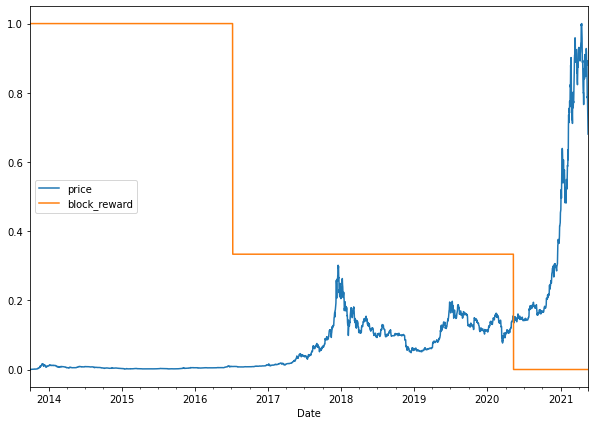

In [49]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

[`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method can create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.


In [50]:
shift_price = bitcoin_prices_block["price"].shift(periods=1)
len(shift_price)==len(bitcoin_prices_block["price"]), shift_price

(True, Date
 2013-10-01             NaN
 2013-10-02      123.654990
 2013-10-03      125.455000
 2013-10-04      108.584830
 2013-10-05      118.674660
                   ...     
 2021-05-14    52147.821187
 2021-05-15    49764.132082
 2021-05-16    50032.693137
 2021-05-17    47885.625255
 2021-05-18    45604.615754
 Name: price, Length: 2787, dtype: float64)

In [51]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


Now that we've got a windowed dataset, let's separate features `X`=Price+1,...Price+7 from labels `y`=price.


We'll also remove the `NaN` values using pandas [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [52]:
X = bitcoin_prices_windowed.dropna().drop("price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["price"].astype(np.float32)

In [53]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [54]:
X_train.to_numpy()[0]

array([ 25.     , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
       125.455  , 123.65499], dtype=float32)

## Model 6: Dense (multivariate time series)

To keep things simple, let's the `model_1` architecture and use it to train and make predictions on our multivariate time series data.

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [78]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
    layers.Input(shape=(8,)),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [81]:
model_6 = tf.keras.models.load_model(f"model_experience/{model_6.name}/")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 572.5060


572.5060424804688

In [90]:
preds_6 = make_preds(model_6, X_test)
scores_6 = evaluate(tf.squeeze(y_test), preds_6)
compare_scores(scores_6)
print()
compare_scores(scores_6, scores_1)

18/18 [==============================] - 0s 2ms/step
Delta mae : -4.5259
Delta mse : -37943.1250
Delta rmse : -17.5659
Delta mape : -0.0618
Delta mase : -0.0062

Delta mae : -9.1321
Delta mse : -33643.5000
Delta rmse : -15.5609
Delta mape : -0.0749
Delta mase : -0.0160


In [93]:
scores_6, scores_1

({'mae': 572.5061,
  'mse': 1185490.1,
  'rmse': 1088.8021,
  'mape': 2.578357,
  'mase': 1.0057347},
 {'mae': 563.37396,
  'mse': 1151846.6,
  'rmse': 1073.2412,
  'mape': 2.5034986,
  'mase': 0.98969203})

## Model 7: N-BEATS algorithm

 [N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm](https://arxiv.org/pdf/1905.10437.pdf) .

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (a forecasting competition).

For our next modelling experiment we're going to be replicating the **generic architecture** of the N-BEATS algorithm (see [section 3.3 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

We're not going to go through all of the details in the paper, instead we're going to focus on:
1. Replicating the model architecture in [Figure 1 of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) 

![figure 1 from N-BBEATS paper, the algorithm we're going to build](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-figure-1-nbeats-paper-annotated.png)
*N-BEATS algorithm we're going to replicate with TensorFlow with window (input) and horizon (output) annotations.*

2. Using the same hyperparameters as the paper which can be found in [Appendix D of the N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)

Doing this will give us an opportunity to practice:
* Creating a custom layer for the `NBeatsBlock` by subclassing [`tf.keras.layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)
  * Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)
* Implementing a custom architecture using the Functional API 
* Finding a paper related to our problem and seeing how it goes 

> 🔑 **Note:** As you'll see in the paper, the authors state “N-BEATS is implemented and trained in TensorFlow”, that's what we'll be doing too!


In [55]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [67]:
layers.Dense(2)(x), x.shape

(<tf.Tensor: shape=(7, 2), dtype=float32, numpy=
 array([[ 28.035484, -28.3363  ],
        [ 28.443588, -28.748783],
        [ 24.618725, -24.882881],
        [ 26.906326, -27.195026],
        [ 27.510317, -27.805498],
        [ 27.35539 , -27.648909],
        [ 27.613781, -27.91007 ]], dtype=float32)>, TensorShape([7, 1]))

In [68]:
x2 = layers.Dense(5)(x)
layers.Dense(1)(x2)

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[55.828682],
       [56.64137 ],
       [49.024696],
       [53.580128],
       [54.78289 ],
       [54.474373],
       [54.988922]], dtype=float32)>

Setting up the `NBeatsBlock` custom layer we see: 
* The class inherits from `tf.keras.layers.Layer` (this gives it all of the methods assosciated with `tf.keras.layers.Layer`)
* The constructor (`def __init__(...)`) takes all of the layer hyperparameters as well as the `**kwargs` argument
  * The `**kwargs` argument takes care of all of the hyperparameters which aren't mentioned in the constructor such as, `input_shape`, `trainable` and `name`
* In the constructor, the block architecture layers are created:
  * The hidden layers are created as a stack of fully connected with `n_nuerons` hidden units layers with ReLU activation
  * The theta layer uses `theta_size` hidden units as well as linear activation
* The `call()` method is what is run when the layer is called:
  * It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation)
  * After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size`) and forecast (forward predictions, shape: `horizon`) are returned

![code mapping to image of N-BEATS basic block](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-basic-block-replication-with-tensorflow-layer-subclassing.png)
*Using TensorFlow layer subclassing to replicate the N-BEATS basic block. See section 3.1 of N-BEATS paper for details.*

Let's see our block replica in action by together by creating a toy version of `NBeatsBlock`.

> 📖  **Resource:** Much of the creation of the time series materials (the ones you're going through now), including replicating the N-BEATS algorithm were streamed live on Twitch. If you'd like to see replays of how the algorithm was replicated, check out the [*Time series research and TensorFlow course material creation playlist*](https://youtube.com/playlist?list=PL8IpyNZ21vUSCM7nRAuS-hW_E-sgwdmaI) on the Daniel Bourke arXiv YouTube channel.

In [57]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [58]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [59]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs) # shape=(1,8)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.34613743  0.35609487  0.09707846  0.5285349   0.4856892   0.098354
  0.5374894 ]
Forecast: 0.4694148600101471


### Preparing data for the N-BEATS algorithm using `tf.data`



In [60]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [61]:
X = bitcoin_prices_nbeats.dropna().drop("price", axis=1)
y = bitcoin_prices_nbeats.dropna()["price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [62]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

To begin, we'll create variables for each of the hyperparameters we'll be using for our N-BEATS replica.

> 📖 **Resource:** The following hyperparameters are taken from Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)
*Table 18 from [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) describing the hyperparameters used for the different variants of N-BEATS. We're using N-BEATS-G which stands for the generic version of N-BEATS.*

> 🔑 **Note:** If you see variables in a machine learning example in all caps, such as "`N_EPOCHS = 100`", these variables are often hyperparameters which are used through the example. You'll usually see them instantiated towards the start of an experiment and then used throughout.



In [63]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Beautiful! Hyperparameters ready, now before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS **double residual stacking** (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:
* [`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract) - subtracts list of input tensors from each other
* [`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add) - adds list of input tensors to each other

Let's try them out.

In [64]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]



The power of **residual stacking** or **residual connections** was revealed in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts. 

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.

> What is a residual connection?

A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:
* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack 

![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)
*Annotated version of Figure 1 from the N-BEATS paper highlighting the double residual stacking (section 3.2) of the architecture. Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.*

> What are the benefits of residual connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).  

It's thought that they help avoid the problem of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (patterns learned by a neural network not being passed through to deeper layers).



### Building, compiling and fitting the N-BEATS algorithm 

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

Woah. A bunch of steps. But I'm sure you're up to it.

Let's do it!

In [72]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 179: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 285: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 385: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 2min 7s, sys: 2.42 s, total: 2min 9s
Wall time: 2min 41s


In [73]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 44ms/step - loss: 587.4100 - mae: 587.4100 - mse: 1197616.2500


[587.4100341796875, 587.4100341796875, 1197616.25]

In [74]:
preds_7 = make_preds(model_7, test_dataset)
scores_7 = evaluate(tf.squeeze(y_test), preds_7)
compare_scores(scores_7)

1/1 [==============================] - 2s 2s/step
Delta mae : -19.4298
Delta mse : -50069.2500
Delta rmse : -23.1204
Delta mape : -0.1945
Delta mase : -0.0323


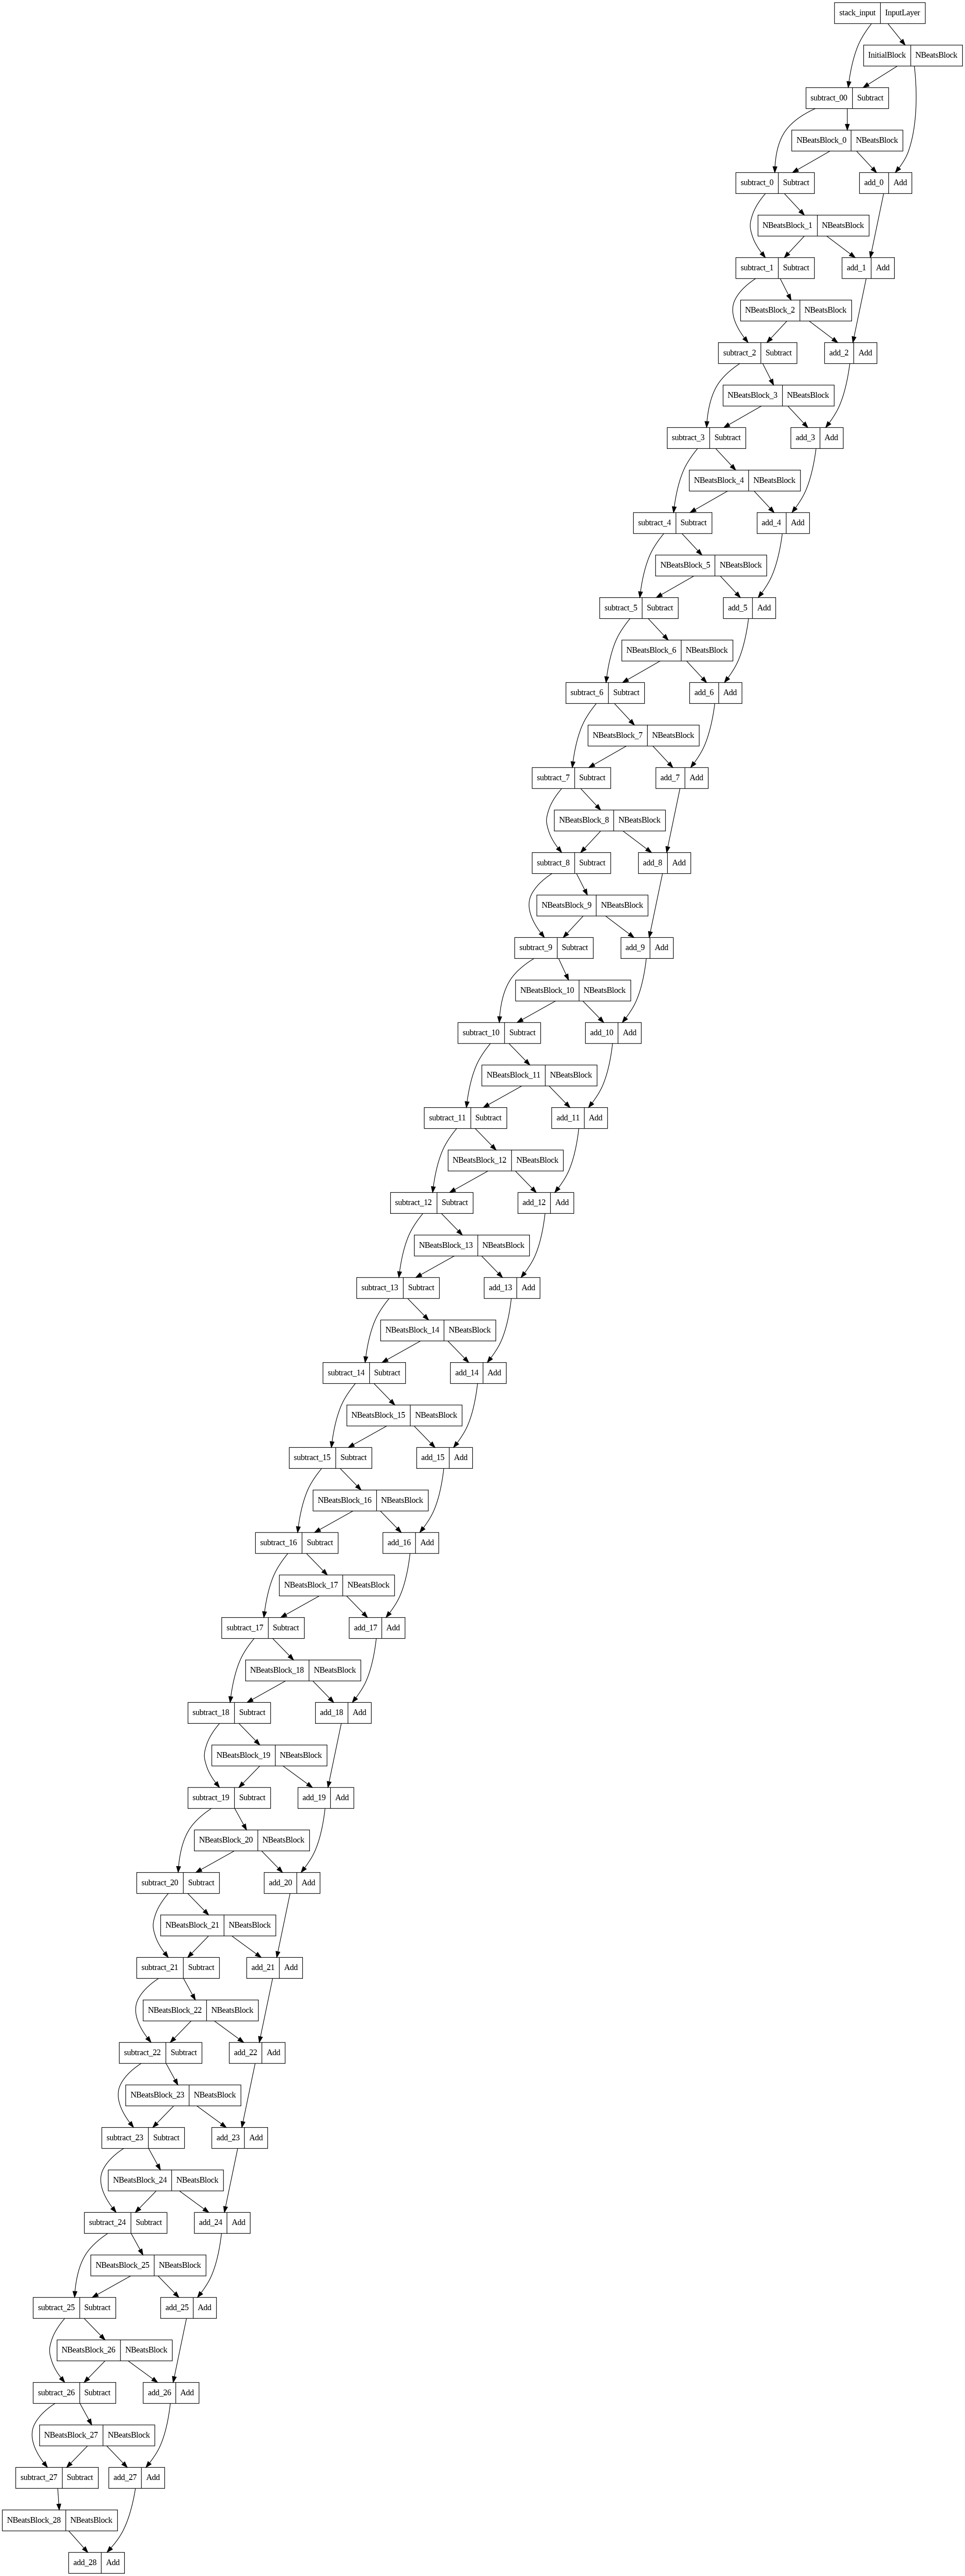

In [75]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

Now that is one good looking model! 

It even looks similar to the model shown in Figure 1 of the N-BEATS paper. 

![N-BEATS replica model compared with actual N-BEATS architecture](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-stack-model-vs-nbeats-architecture.png)
*Comparison of `model_7` (N-BEATS replica model make with Keras Functional API) versus actual N-BEATS architecture diagram.*

Looks like our Functional API usage did the trick! 

> 🔑 **Note:** Our N-BEATS model replicates the N-BEATS **generic architecture**, the training setups are largely the same, except for the N-BEATS paper used an ensemble of models to make predictions (multiple different loss functions and multiple different lookback windows), see Table 18 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) for more. An extension could be to setup this kind of training regime and see if it improves performance.

How about we try and save our version of the N-BEATS model?

## Model 8: Creating an ensemble (stacking different models together)

Our next experiment is creating an [**ensemble** of models](https://en.wikipedia.org/wiki/Ensemble_learning).

An **ensemble** involves training and combining multiple different models on the same problem. Ensemble models are often the types of models you'll see winning data science competitions on websites like Kaggle.


For example, in the N-BEATS paper, they trained an ensemble of models (180 in total, see [section 3.4](https://arxiv.org/pdf/1905.10437.pdf)) to achieve the results they did using a combination of:
  * Different loss functions (sMAPE, MASE and MAPE)
  * Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)

The benefit of ensembling models is you get the "decision of the crowd effect". Rather than relying on a single model's predictions, you can [take the average or median of many different models](https://en.wikipedia.org/wiki/Ensemble_forecasting).

**The keyword being: different.**


In [83]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):

    ensemble_models = []
    for i in range(5):
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, iter n°{i+1}")

            model = tf.keras.Sequential([
            # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
            # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
            layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
            layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
            layers.Dense(HORIZON)                                 
            ])

            model.compile(loss=loss_function,
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["mae", "mse"])
            
            model.fit(train_data,
                    epochs=num_epochs,
                    verbose=0,
                    validation_data=test_data,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                patience=200,
                                                                restore_best_weights=True),
                                tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                    patience=100,
                                                                    verbose=1)])
            
            # Append fitted model to list of ensemble models
            ensemble_models.append(model)

    return ensemble_models # return list of trained models

In [84]:
%%time
ensemble_models = get_ensemble_models(num_epochs=100)

Optimizing model by reducing: mae for 100 epochs, iter n°1
Optimizing model by reducing: mse for 100 epochs, iter n°1
Optimizing model by reducing: mape for 100 epochs, iter n°1
Optimizing model by reducing: mae for 100 epochs, iter n°2
Optimizing model by reducing: mse for 100 epochs, iter n°2
Optimizing model by reducing: mape for 100 epochs, iter n°2
Optimizing model by reducing: mae for 100 epochs, iter n°3
Optimizing model by reducing: mse for 100 epochs, iter n°3
Optimizing model by reducing: mape for 100 epochs, iter n°3
Optimizing model by reducing: mae for 100 epochs, iter n°4
Optimizing model by reducing: mse for 100 epochs, iter n°4
Optimizing model by reducing: mape for 100 epochs, iter n°4
Optimizing model by reducing: mae for 100 epochs, iter n°5
Optimizing model by reducing: mse for 100 epochs, iter n°5
Optimizing model by reducing: mape for 100 epochs, iter n°5
CPU times: user 1min 19s, sys: 4.13 s, total: 1min 23s
Wall time: 1min 31s


In [85]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [86]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 44ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 7557.248 ,  7287.7036,  7145.801 , ..., 40921.453 , 39693.574 ,
        37609.535 ],
       [ 8717.381 ,  8795.682 ,  9069.492 , ..., 50240.4   , 47467.06  ,
        47186.812 ],
       [ 8636.845 ,  8614.802 ,  8910.425 , ..., 48698.52  , 46986.547 ,
        45051.16  ],
       ...,
       [ 7273.1084,  7524.751 ,  7970.046 , ..., 46069.79  , 39136.56  ,
        36434.305 ],
       [ 8727.535 ,  8443.66  ,  8785.352 , ..., 49491.754 , 49151.42  ,
        45392.15  ],
       [ 8282.456 ,  8327.552 ,  8579.383 , ..., 46868.934 , 45423.574 ,
        43300.402 ]], dtype=float32)>

In [87]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate(y_true=y_test,
                            y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 663.9371,
 'mse': 1364475.0,
 'rmse': 1168.1074,
 'mape': 3.1079316,
 'mase': 1.1663536}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

In [93]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): 
  std = tf.math.reduce_std(preds, axis=0)
  
  # Multiply the standard deviation by 1.96
  # Get the upper and lower bounds of the 95% (verify)
  interval = 1.96 * std  

  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

lower, upper = get_upper_lower(preds=ensemble_preds)

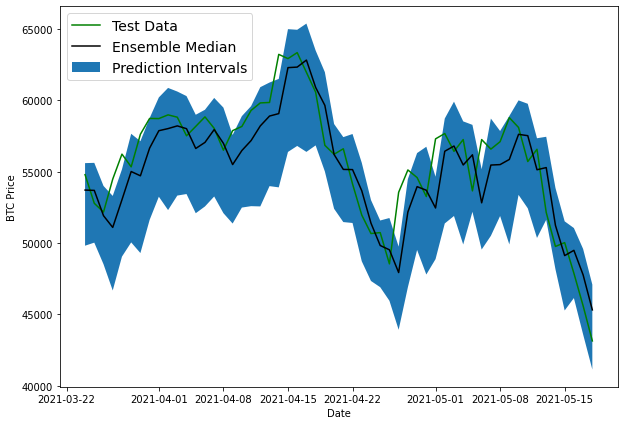

In [92]:
ensemble_median = np.median(ensemble_preds, axis=0)

offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 lower[offset:], 
                 upper[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);